Customer Segmentation Project

Goals:

1. Database preparation
   
1.1 Check the error in the database

1.2 Create new database and import tables

1.3 Connect to the database

1.4 Query the tables

2. Analyzing Data

2.1 Separate returns of goods to see the cancellation rate 

2.2 Customer Segmentation

2.2.1 Geographical Segmentation

2.2.1.1 Popular Regions

2.2.1.2 Least Popular Regions

2.2.1.3 Segmentation by average Price per order 


2.2.2 Temporal Segmentation

2.2.2.1 Number of Orders per Month 

2.2.2.2 Number of Orders per Weekday

2.2.2.3 Number of Orders per Day


2.2.3 Customer Segmentation (RFM)


3. Conclusions and Recommendations

In [242]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter,MonthLocator,YearLocator,MonthLocator,WeekdayLocator
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

1. Database preparation

1.1 Check the error in the database

In [243]:
C = conn.cursor()
C.execute('pragma encoding')

In [244]:
rows = C.fetchall()
for row in rows: 
    print(row)

('UTF-8',)


1.2 Create new database and import tables

In [245]:
import sqlite3

conn = sqlite3.connect('db_bootcamp.db')
cursor = conn.cursor()


In [246]:
import pandas as pd

# CSV-Datei einlesen
df = pd.read_csv('online_transactions_2.csv')

# CSV-Daten in die Datenbanktabelle einfügen
df.to_sql('online_transactions', conn, if_exists='append', index=False)


541910

1.3 Connect to the database

In [477]:
import sqlite3

# connection to the SQLite database
conn = sqlite3.connect('db_bootcamp.db')
cursor = conn.cursor()

# SQL query to get all table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Retrieve all table names from the cursor
tabellen = cursor.fetchall()

# Output tables
for tabelle in tabellen:
    print(tabelle[0])



online_transactions
stock_description
online_transactions_cleaned


In [248]:
cursor.execute("DROP TABLE IF EXISTS online_transactions_2;")


In [249]:
cursor.execute("DROP TABLE IF EXISTS stock_description_2;")


In [250]:
cursor.execute("DROP TABLE IF EXISTS online_transactions_cleaned_2;")


In [251]:
conn.commit()


In [252]:
conn

In [253]:
sql_query = """SELECT name 
               FROM sqlite_master 
               WHERE type='table';"""

cursor = conn.cursor()

# executing our sql query
cursor.execute(sql_query)

 
# printing all tables list
print(f"List of tables in the database:\n{cursor.fetchall()}")

List of tables in the database:
[('online_transactions',), ('stock_description',), ('online_transactions_cleaned',)]


1.4 Query the tables

For further analysis, we work with the online_transactions_cleaned table, which contains the pre-processed data.
(Duplicates and null ariables were removed, quantities with negative values were excluded)

In [254]:
# query the table with cleaned data
query = """SELECT *
               FROM online_transactions_cleaned
               WHERE quantity >= 0 AND price >= 0;
               """

clean_data = pd.read_sql(query, conn)

In [255]:
clean_data.shape

(1174002, 9)

In [256]:
clean_data.head()

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,2010-12-01 08:45:00,1.25,24,30.00,u12583,France
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,2010-12-01 09:02:00,2.55,6,15.30,u1785,United Kingdom
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,2010-12-01 09:37:00,1.95,10,19.50,u14688,United Kingdom
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2010-12-01 09:41:00,2.95,1,2.95,u15311,United Kingdom
4,536381,15056BL,EDWARDIAN PARASOL BLACK,2010-12-01 09:41:00,5.95,2,11.90,u15311,United Kingdom


In [257]:
clean_data.describe()

,price,quantity,total_order_value
count,1.174002e+06,1.174002e+06,1.174002e+06
mean,2.920468e+00,1.317420e+01,2.237288e+01
std,7.267541e+00,1.818717e+02,3.109108e+02
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.250000e+00,2.000000e+00,4.950000e+00
50%,1.950000e+00,6.000000e+00,1.190000e+01
75%,3.750000e+00,1.200000e+01,1.980000e+01
max,1.599260e+03,8.099500e+04,1.684696e+05


In [258]:
# structure of the data
clean_data.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174002 entries, 0 to 1174001
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   invoice            1174002 non-null  object 
 1   stock_code         1174002 non-null  object 
 2   description        1174002 non-null  object 
 3   invoice_date       1174002 non-null  object 
 4   price              1174002 non-null  float64
 5   quantity           1174002 non-null  int64  
 6   total_order_value  1174002 non-null  float64
 7   customer_id        1174002 non-null  object 
 8   country            1174002 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 80.6+ MB


In [259]:
# general information
query="""
      SELECT COUNT(DISTINCT customer_id) AS number_customers,
             COUNT(DISTINCT invoice) AS number_orders,
             MIN(invoice_date) AS first_purchase,
             MAX(invoice_date) AS last_purchase,
             AVG(total_order_value) AS average_order_value,
             COUNT(DISTINCT country) AS number_country,
             COUNT(DISTINCT stock_code) AS number_distinct_items,
             COUNT(DISTINCT description) AS number_description,
             COUNT(DISTINCT substr(invoice_date,1,4)) AS number_years,
             COUNT(DISTINCT substr(invoice_date,1,7)) AS number_months,
             COUNT(CASE WHEN description='UNKNOWN' THEN 1 ELSE Null END) AS number_unknown_description
      FROM online_transactions_cleaned
      """
pd.read_sql(query,conn)

,number_customers,number_orders,first_purchase,last_purchase,average_order_value,number_country,number_distinct_items,number_description,number_years,number_months,number_unknown_description
0,4363,21791,2010-12-01 08:26:00,2011-12-09 12:50:00,20.716904,37,3679,3644,2,13,3516


first conclusions:
- purchase data from 1 Year  (12/2010-12/2011)
- 4363 customers from 37 countries
- 21791 orders in 1 year
- 3679 different item types in sale, but only 3644 item descriptions --> 35 undescribed items types
- average order value around 21 in a price range from 0,00 to 1599,26 

Analysis Questions:
- how many return of goods were made // cancellation rate?
- Customer segmentation by country --> amount spent?
- Customer segmention by buying behavior (RFM)

2. Analyzing Data

2.1 Separate returns of goods to see the cancellation rate 

In [260]:
# handle returned or cancelled orders

query = """

WITH transaction_pairs AS (
    SELECT
        t1.invoice AS invoice1,
        t2.invoice AS invoice2,
        t1.stock_code,
        t1.description,
        t1.invoice_date AS invoice_date1,
        t2.invoice_date AS invoice_date2,
        t1.price,
        t1.quantity AS quantity1,
        t2.quantity AS quantity2,
        t1.customer_id,
        t1.country
    FROM
        online_transactions_cleaned t1
    JOIN
        online_transactions_cleaned t2
    ON
        t1.stock_code = t2.stock_code AND
        t1.description = t2.description AND
        t1.price = t2.price AND
        t1.customer_id = t2.customer_id AND
        t1.quantity = -t2.quantity AND
        t1.quantity > 0
)
-- Select all transactions that are not part of a matched pair
SELECT
    *
FROM
    online_transactions_cleaned
WHERE
    invoice NOT IN (SELECT invoice1 FROM transaction_pairs)
    AND
    invoice NOT IN (SELECT invoice2 FROM transaction_pairs)
    AND quantity > 0;
    """

return_cleaned = pd.read_sql(query, conn)

In [261]:
return_cleaned.describe()

,price,quantity,total_order_value
count,973458.000000,973458.000000,973458.000000
mean,2.891756,12.865766,21.789280
std,7.658623,47.835400,95.716069
min,0.000000,1.000000,0.000000
25%,1.250000,2.000000,4.950000
50%,1.950000,6.000000,12.500000
75%,3.750000,12.000000,19.800000
max,1599.260000,12540.000000,38970.000000


In [262]:
return_cleaned.shape

(973458, 9)

In [263]:
return_cleaned.head()

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,2010-12-01 08:45:00,1.25,24,30.00,u12583,France
1,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,2010-12-01 09:37:00,1.95,10,19.50,u14688,United Kingdom
2,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2010-12-01 09:41:00,2.95,1,2.95,u15311,United Kingdom
3,536381,15056BL,EDWARDIAN PARASOL BLACK,2010-12-01 09:41:00,5.95,2,11.90,u15311,United Kingdom
4,536381,22438,BALLOON ART MAKE YOUR OWN FLOWERS,2010-12-01 09:41:00,1.95,1,1.95,u15311,United Kingdom


Findings:

- return_cleaned data gives a  number of 973458 orders (1174002 with returns) --> there is a 17 percent return of goods quote
--> this is normal value for returns of goods

2.2 Customer Segmentation

2.2.1 Geographical Segmentation

2.2.1.1 Popular Regions

In [265]:
#segmentation number of orders by country

country_num_orders = clean_data.groupby('country').agg(
    num_orders=('invoice', 'nunique'),
    total_order_value=('total_order_value', 'sum')
).sort_values('num_orders', ascending=False).reset_index()

In [266]:
country_num_orders.head(10)

,country,num_orders,total_order_value
0,United Kingdom,16581,2.176705e+07
1,Germany,443,6.161434e+05
2,France,380,5.519638e+05
3,EIRE,258,7.856644e+05
4,Belgium,98,1.107820e+05
5,Netherlands,94,8.516680e+05
6,Spain,88,1.671197e+05
7,Australia,56,4.143114e+05
8,Portugal,49,7.993170e+04
9,Switzerland,47,1.573259e+05


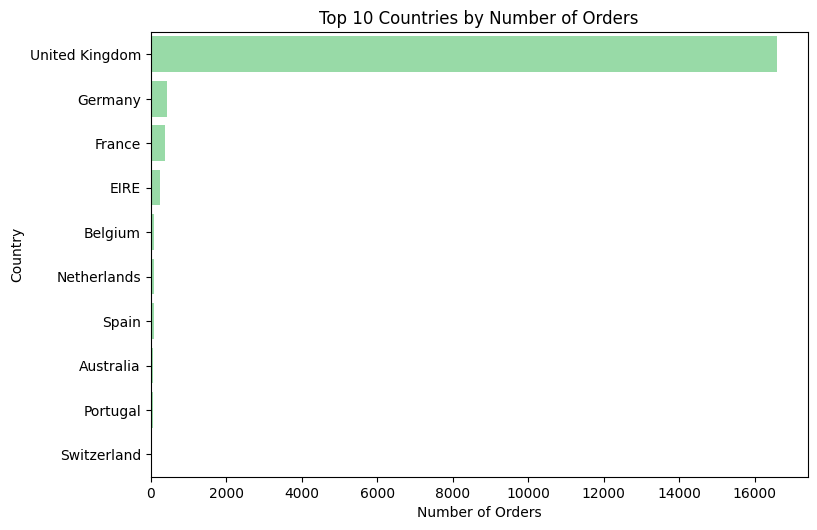

In [267]:
# visualization

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
sns.barplot(x='num_orders', y='country', data = country_num_orders.sort_values('num_orders', ascending=False).head(10), color='#8de5a1')
plt.title('Top 10 Countries by Number of Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Country') 
plt.tight_layout()
plt.show()

In [268]:
#segmentation total order value by country

country_total_value = clean_data.groupby('country').agg(
    num_orders=('invoice', 'nunique'),
    total_order_value=('total_order_value', 'sum')
).sort_values('total_order_value', ascending=False).reset_index()

In [269]:
country_total_value.head(10)

,country,num_orders,total_order_value
0,United Kingdom,16581,2.176705e+07
1,Netherlands,94,8.516680e+05
2,EIRE,258,7.856644e+05
3,Germany,443,6.161434e+05
4,France,380,5.519638e+05
5,Australia,56,4.143114e+05
6,Spain,88,1.671197e+05
7,Switzerland,47,1.573259e+05
8,Japan,19,1.122491e+05
9,Belgium,98,1.107820e+05


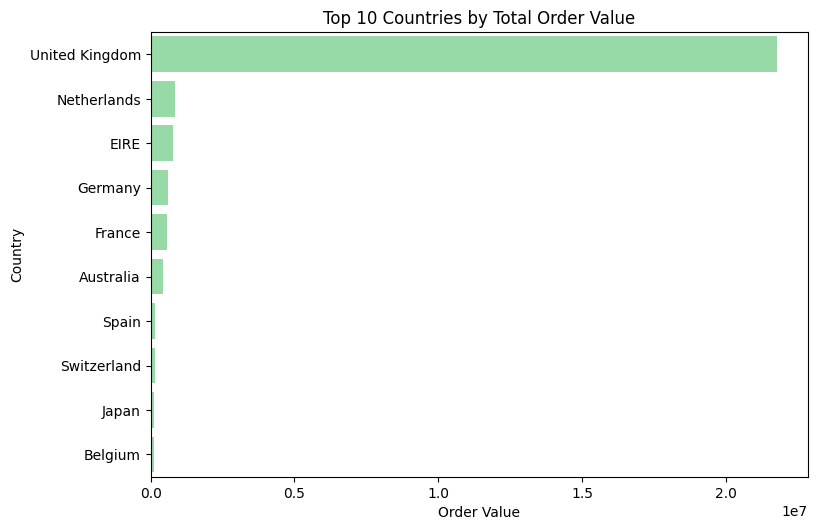

In [270]:
# visualization

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
sns.barplot(x='total_order_value', y='country', data = country_total_value.sort_values('total_order_value', ascending=False).head(10), color='#8de5a1')
plt.title('Top 10 Countries by Total Order Value')
plt.xlabel('Order Value')
plt.ylabel('Country') 
plt.tight_layout()
plt.show()

In [271]:
country_total_value = clean_data.groupby('country').agg(
    num_orders=('invoice', 'nunique'),
    total_order_value=('total_order_value', 'sum')
).sort_values('total_order_value', ascending=False).reset_index()

In [272]:
country_total_value.head(10)

,country,num_orders,total_order_value
0,United Kingdom,16581,2.176705e+07
1,Netherlands,94,8.516680e+05
2,EIRE,258,7.856644e+05
3,Germany,443,6.161434e+05
4,France,380,5.519638e+05
5,Australia,56,4.143114e+05
6,Spain,88,1.671197e+05
7,Switzerland,47,1.573259e+05
8,Japan,19,1.122491e+05
9,Belgium,98,1.107820e+05


In [273]:
# visualization as heatmap // installation

!pip3 install plotly

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip


In [478]:
# visualization as heatmap

import plotly.express as px

fig = px.choropleth(country_total_value, 
                    locations='country',
                    locationmode='country names', 
                    color='total_order_value',
                    color_continuous_scale='deep',
                    title='Sales Density by Country')

# Show the figure
fig.show()

2.2.1.2 Least Popular Regions

In [275]:
country_low = clean_data.groupby('country').agg(
    num_orders=('invoice', 'nunique'),
    total_order_value=('total_order_value', 'sum')
).sort_values('num_orders', ascending=True).reset_index()

In [276]:
country_low.head(10)

,country,num_orders,total_order_value
0,Brazil,1,3430.80
1,Saudi Arabia,1,437.76
2,RSA,1,3006.93
3,Lebanon,1,5081.64
4,Czech Republic,2,2360.22
5,Bahrain,2,1645.20
6,United Arab Emirates,2,5594.34
7,European Community,3,3477.75
8,Singapore,4,27361.17
9,Lithuania,4,4983.18


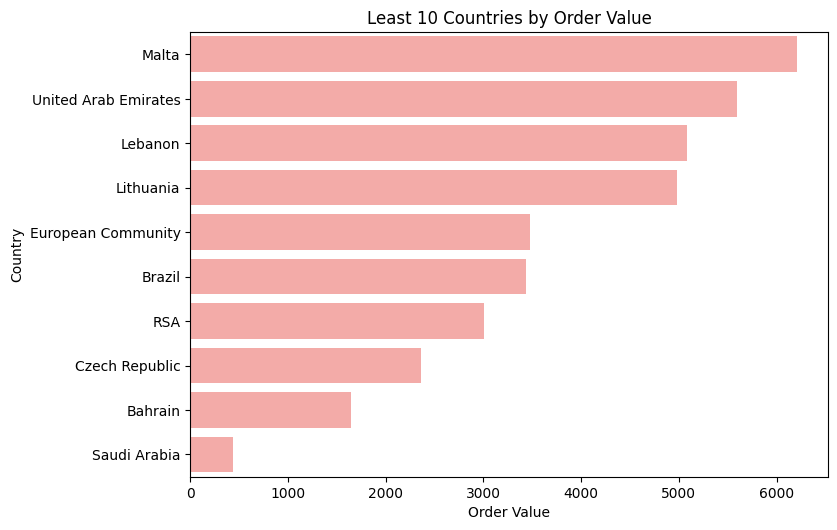

In [277]:
# visualization

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
sns.barplot(x='total_order_value', y='country', data = country_low.sort_values('total_order_value', ascending=False).tail(10), color='#ff9f9b')
plt.title('Least 10 Countries by Order Value')
plt.xlabel('Order Value')
plt.ylabel('Country') 
plt.tight_layout()
plt.show()

Findings:
- majority of orders come from the UK market - in number of orders and total value (not surprising)
- Germany, France and EIRE, which are neighbour countries, follow in order of number of orders - with a major gap to the UK market 
- but: second place, in terms of total order value, is taken by the Netherlands, followed by EIRE, Germany, France and Australia - also with a major gap to the UK market

Explanation:
- the UK market ist pioneer and the main market, for sure
- neighbour countries, like Germany, Netherlands, EIRE and France follow in the ranking
  --> the further away from the main market, the more irrelevant the offer is to other countries; except Australia, which is part of the Commonwealth and therefore also attractive for the main market
  --> another exception is Japan, which shows a low number of orders but a high total order value --> this could be a pretty attractive market for hihg-pricing products
- although Australia is part of the top 10 countries with the most orders, orders with a higher value are predominantly to be expected here, as delivery costs and distances are still long
- lowest order values and number of orders come from mid-east areas 

2.2.1.3 Segmentation by average Price per order 

In [278]:
# countries by average price of order 
clean_data.groupby('country')['price'].mean().sort_values(ascending=False)

country
Lebanon                 5.387556
Cyprus                  5.208752
Bahrain                 4.644118
Brazil                  4.456250
RSA                     4.352632
European Community      4.242105
Channel Islands         4.148794
EIRE                    3.980158
Italy                   3.739825
Singapore               3.679488
Malta                   3.671468
Israel                  3.667714
Greece                  3.649930
Poland                  3.622185
Norway                  3.271373
Unspecified             3.219710
Spain                   3.207771
Belgium                 3.042817
Austria                 2.984115
Finland                 2.962658
United Kingdom          2.902129
United Arab Emirates    2.871493
Switzerland             2.864865
Lithuania               2.841143
Australia               2.752113
Germany                 2.721232
France                  2.674306
Iceland                 2.644011
Denmark                 2.636376
Portugal                2.550664
Ne

In [279]:
# distribution of price by country
country_price=clean_data['country'].unique()

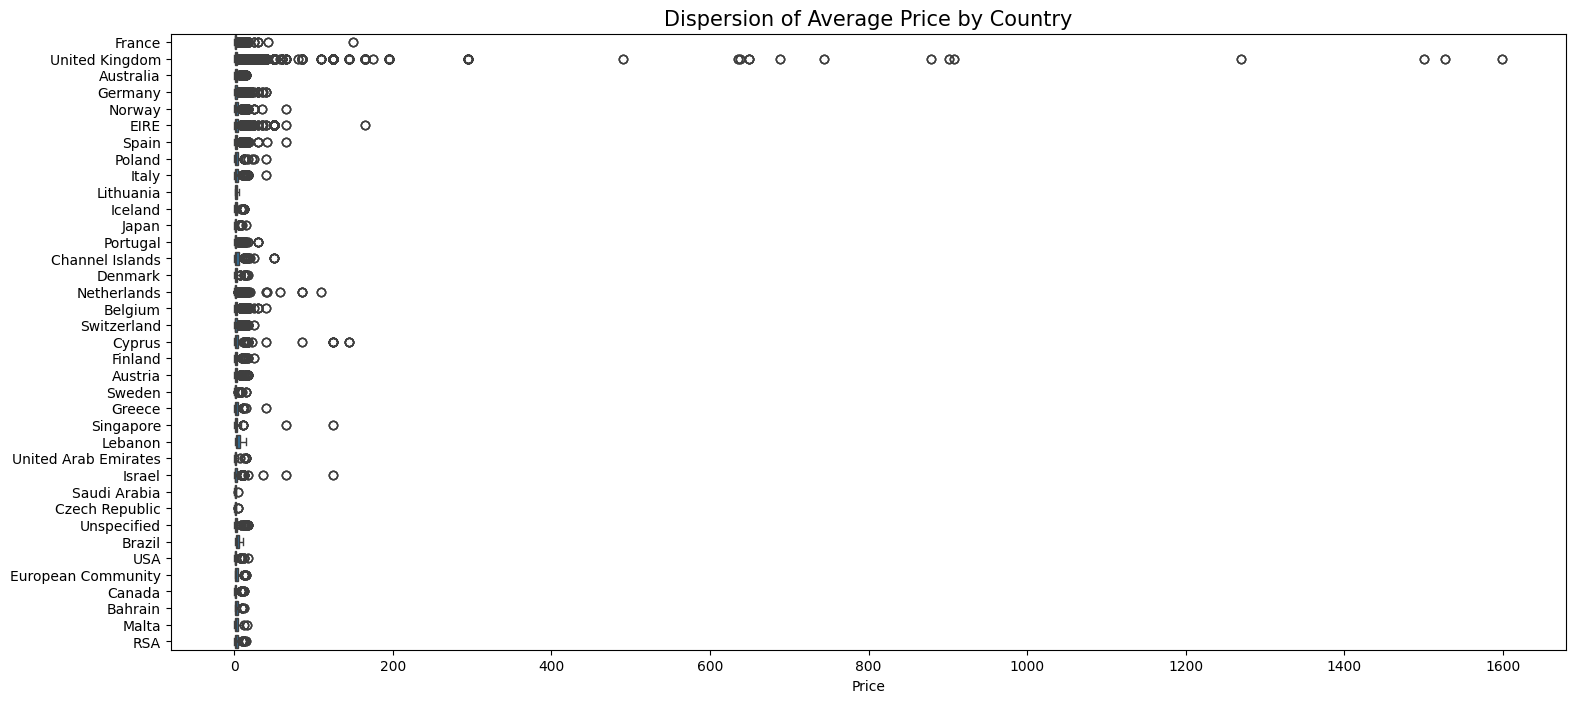

In [280]:
# Visualizing the dispersion of average prices by country

plt.figure(figsize=(18,8))

sns.boxplot(y='country',x='price',data=clean_data)
plt.title("Dispersion of Average Price by Country",size=15)
plt.xlabel("Price")
plt.ylabel('') 
plt.show()

Findings: 

- no orders up to 200 were made from other countries than the UK --> UK remarks the highest order values, even tough most orders range from 0 to 67
  
- but the average prices per order vary from 5.39 (max) to 1.59 (min), where UK is below the mean (mean 3.49; UK 2.9)
- Countries with a high number of orders have lower average prices per order --> here orders with a lower total order value are placed more often, whereas countries that are further away place fewer orders with a higher total order value
  --> Delivery times and costs can explain this
- still, the UK represents the statistical mid-part, which is not surprising as it is by far the country with the most orders

2.2.2 Temporal Segmentation

2.2.2.1 Number of Orders per Month 

- since we only have 1 year of data available, an annual analysis makes no sense
- therefore the coarsest unit of analysis is "month" (data for December is considered as one value, as the complete data set extends from 2010-12-01 to 2011-12-09 and therefore covers an almost complete year

In [282]:
# Change the type of invoice_date
date_clean = clean_data.assign(invoice_date=lambda x: pd.to_datetime(x['invoice_date']))

In [283]:
clean_data['invoice_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1174002 entries, 0 to 1174001
Series name: invoice_date
Non-Null Count    Dtype 
--------------    ----- 
1174002 non-null  object
dtypes: object(1)
memory usage: 9.0+ MB


In [284]:
# extract month from invoice date
date_clean['month']=date_clean['invoice_date'].dt.month

In [286]:
date_clean.head()

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country,month
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,2010-12-01 08:45:00,1.25,24,30.00,u12583,France,12
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,2010-12-01 09:02:00,2.55,6,15.30,u1785,United Kingdom,12
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,2010-12-01 09:37:00,1.95,10,19.50,u14688,United Kingdom,12
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2010-12-01 09:41:00,2.95,1,2.95,u15311,United Kingdom,12
4,536381,15056BL,EDWARDIAN PARASOL BLACK,2010-12-01 09:41:00,5.95,2,11.90,u15311,United Kingdom,12


In [285]:
orders_per_month=date_clean.groupby('month')[['quantity']].sum()

In [310]:
# Calculate the total quantity per month
orders_per_month=date_clean.groupby('month')[['quantity']].sum()

In [290]:
orders_per_month

,quantity
month,
1,1044693
2,794415
3,1041894
4,873384
5,1118037
6,1088208
7,1101228
8,1193769
9,1628550


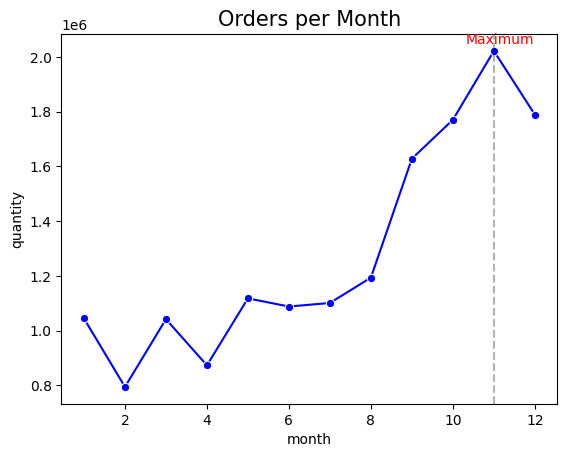

In [383]:
#visualization

sns.lineplot(x='month',y='quantity',data=orders_per_month,marker='o',color='blue')

plt.title('Orders per Month',fontsize=15)
plt.xlabel('month')
plt.ylabel('quantity')
plt.axvline(11, color = "k", linestyle = '--', alpha = 0.3)

# name the highest point 
plt.text(10.3, 2.05e6, "Maximum", size=10, color='red')

plt.show()

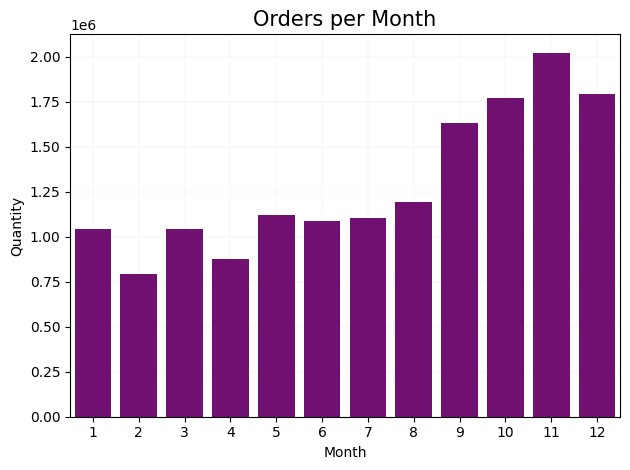

In [357]:
# visualization

sns.barplot(x='month',y='quantity',data=orders_per_month, color = 'purple')
plt.title('Orders per Month',size=15)
plt.xlabel("Month")
plt.ylabel("Quantity")
plt.grid (color='gray',linestyle='-',linewidth=0.05)

plt.tight_layout()
plt.show()

In [ ]:
2.2.2.2 Number of Orders per Weekday

In [311]:
# Create a dictionary that maps numbers to the abbreviations of weekdays

weekday_map = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun'
}

In [376]:
#extract weekday from date 
date_clean['weekday']=date_clean['invoice_date'].dt.weekday

In [373]:
# Orders per Weekday
orders_weekday = date_clean.groupby('weekday')['quantity'].sum()


Text(0, 0.5, 'Quantity')

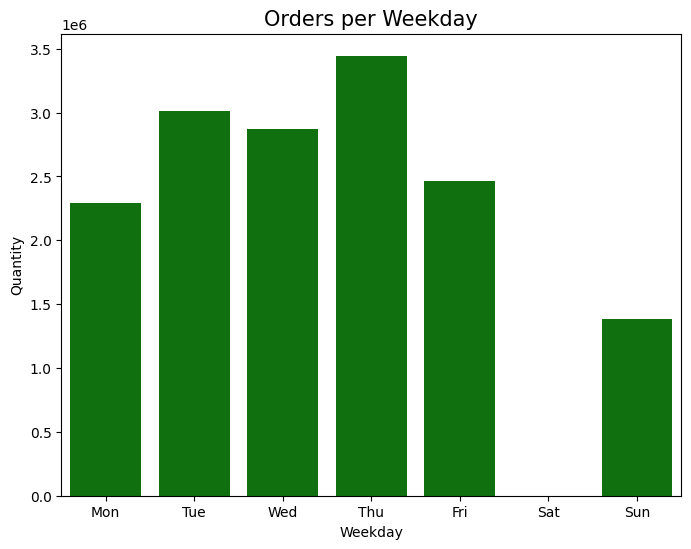

In [374]:
# visualization

weekdays_list = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(8, 6))
sns.barplot(x=weekdays_list, y=quantity, color = 'green')
plt.title('Orders per Weekday',size=15)
plt.xlabel('Weekday')
plt.ylabel('Quantity')

2.2.2.3 Number of Orders per Day

In [369]:
# Distribution of Transactions per Day
# Extract day from invoice date
date_clean['day']=date_clean['invoice_date'].dt.day

In [371]:
date_clean.head()

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country,month,weekday,day
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,2010-12-01 08:45:00,1.25,24,30.00,u12583,France,12,Wed,1
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,2010-12-01 09:02:00,2.55,6,15.30,u1785,United Kingdom,12,Wed,1
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,2010-12-01 09:37:00,1.95,10,19.50,u14688,United Kingdom,12,Wed,1
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2010-12-01 09:41:00,2.95,1,2.95,u15311,United Kingdom,12,Wed,1
4,536381,15056BL,EDWARDIAN PARASOL BLACK,2010-12-01 09:41:00,5.95,2,11.90,u15311,United Kingdom,12,Wed,1


In [378]:
# Quantity per weekday
orders_day = date_clean.groupby('day')[['quantity']].sum().reset_index()

In [379]:
orders_day

,day,quantity
0,1,509871
1,2,456825
2,3,440550
3,4,575949
4,5,643854
5,6,592794
6,7,615951
7,8,519306
8,9,740379
9,10,490593


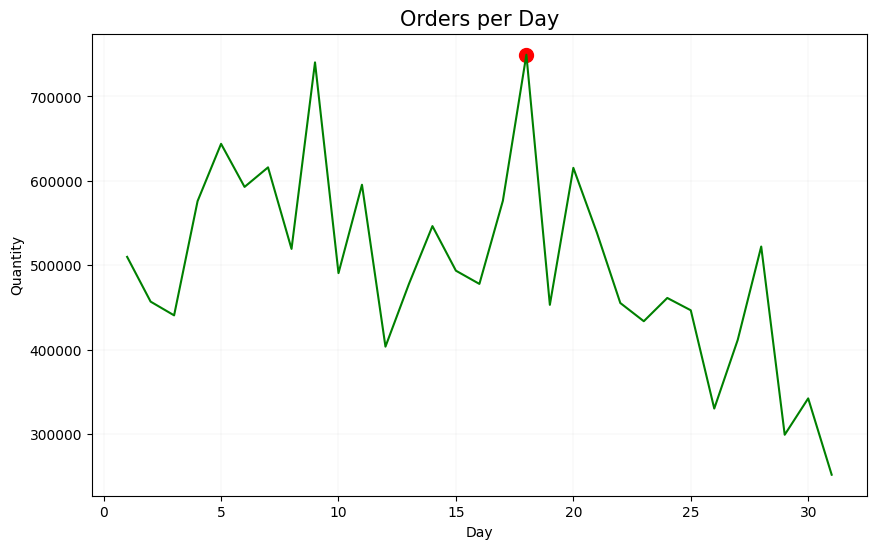

In [391]:
# visualization 

plt.figure(figsize=(10,6))
sns.lineplot(x='day',y='quantity',data=orders_day, color = 'green')

# Find the highest point
max_quantity = orders_day['quantity'].max()
max_day = orders_day[orders_day['quantity'] == max_quantity]['day'].values[0]

# Color the highest point
plt.scatter(max_day, max_quantity, color='red', s=100)  

# Add titel and labels
plt.title('Orders per Day',size=15)
plt.xlabel('Day')
plt.ylabel('Quantity')
plt.grid (color='gray',linestyle='-',linewidth=0.05)

Findings: 

months:
- most orders were placed in November (11), followed by December, October and September
- the first 8 months of the year were significantly less frequented in orders 
--> this can be explained by the fact that the Christmas and therefore shopping season starts at the end of the year for most of the customers (Europe)

weekdays:
- most transactions were made on thursdays --> from Monday to Thursday, sales increase steadily; from Thursday they fall sharply
- no transactions are recorded on Saturdays (Why?)
- in general, the first half of the week is significantly stronger in terms of sales

days:
- most orders are placed shortly after the middle of the month - around the 18th -; a second peak occurs around the 9th of a month
    --> these are by far the busiest days 
    --> one explanation may be that there are usually salary payments at the beginning or in the middle of the month, which cause the upward spikes as fresh money is available in households 

2.2.3 Customer Segmentation (RFM)

In [417]:
print(clean_data['invoice_date'].dtype)


object


In [418]:
clean_data['invoice_date'] = pd.to_datetime(clean_data['invoice_date'])


In [433]:
print(clean_data['invoice_date'].isna().sum())

0


In [442]:
# Calculate Recency, Frequency and Monetary value for each customer 

rfm_data = clean_data.groupby('customer_id').agg({
    'invoice_date': lambda x: (pd.to_datetime('2024-08-13') - x.max()).days,  # Recency: Days since the last order
    'invoice': 'nunique',                                                     # Frequency: Number of orders
    'total_order_value': 'sum'                                                # Monetary: Sum of the order values
}).reset_index()

# rename columns
rfm_data.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

rfm_data.head(10)

,customer_id,Recency,Frequency,Monetary
0,u12346,4955,1,231550.80
1,u12347,4632,7,12930.00
2,u12348,4705,4,4311.72
3,u12349,4648,1,4372.65
4,u1235,4940,1,883.20
5,u12352,4666,7,4157.22
6,u12353,4834,1,267.00
7,u12354,4862,1,3238.20
8,u12355,4844,1,1378.20
9,u12356,4652,3,7462.29


In [443]:
# Scoring RFM metrics (5x5x5)

# Recency-Score (the smaller, the better)
rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Frequency-Score (the bigger, the better)
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# Monetary-Score (the bigger, the better)
rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'], 5, labels=[1, 2, 3, 4, 5])


In [444]:
# Create RFM segment
rfm_data['RFM_Segment'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str) + rfm_data['M_Score'].astype(str)

# RFM-Score berechnen (Summe der Scores)
rfm_data['RFM_Score'] = rfm_data[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)


In [445]:
print(rfm_data)

     customer_id  Recency  Frequency   Monetary R_Score F_Score M_Score  \
0         u12346     4955          1  231550.80       1       1       5   
1         u12347     4632          7   12930.00       5       5       5   
2         u12348     4705          4    4311.72       2       4       4   
3         u12349     4648          1    4372.65       4       1       4   
4          u1235     4940          1     883.20       1       1       2   
...          ...      ...        ...        ...     ...     ...     ...   
4330       u1828     4907          1     541.80       1       2       1   
4331      u18281     4810          1     242.46       1       2       1   
4332      u18282     4637          2     534.15       5       3       1   
4333      u18283     4633         16    6118.74       5       5       5   
4334      u18287     4672          3    5511.84       3       4       4   

     RFM_Segment  RFM_Score  
0            115          7  
1            555         15  
2        

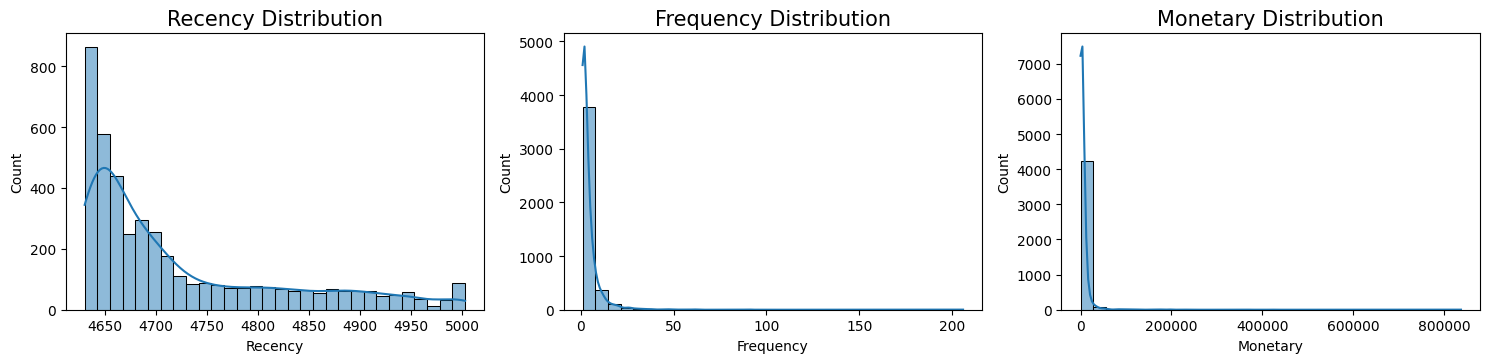

In [455]:
# Visualize the distribution of data
plt.figure(figsize=(15, 10))

# Plot the distribution of the 'Recency' variable
plt.subplot(3, 3, 1)
sns.histplot(rfm_data['Recency'], bins=30, kde=True)
plt.title('Recency Distribution',size=15)

# Plot the distribution of the 'Frequency' variable
plt.subplot(3, 3, 2)
sns.histplot(rfm_data['Frequency'], bins=30, kde=True)
plt.title('Frequency Distribution',size=15)

# Plot the distribution of the 'MonetaryValue' variable
plt.subplot(3, 3, 3)
sns.histplot(rfm_data['Monetary'], bins=30, kde=True)
plt.title('Monetary Distribution',size=15)

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Display the plot
plt.show()

Summary:

- Recency: Days since the last order
- Frequency: Number of orders
- Monetary: Total spend

- RFM segment: Combination of R, F and M scores 
    --> 555 = very good customer

- RFM score: Sum of the scores to determine the total score of a customer
    --> 15 as maximum (555); 3 as minimum (111)

Findings: 

- most customers made a low number of purchases (1-5 times) --> but we have data from 1 year
--> if the company is a young start-up this may will increase; there is already a high number of repeating purchasers

  
- there are only a few customers with a high total spent; most customers have a low total order value 

In [472]:
#customer segmentation based on the RFM scores

def segment_customer(row):
    if row['RFM_Segment'] == '555':
        return 'Champion'
    elif row['R_Score'] >= 4 and row['F_Score'] >= 4:
        return 'Loyal Customer'
    elif row['R_Score'] == 5 and row['F_Score'] <= 3:
        return 'Potential Loyalist'
    elif row['R_Score'] == 5:
        return 'Recent Customer'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 4:
        return 'At Risk'
    else:
        return 'Sleepyhead'

# Applying the function to the DataFrame
rfm_data['Customer_Segment'] = rfm_data.apply(segment_customer, axis=1)

# show results
print(rfm_data[['customer_id', 'RFM_Segment', 'Customer_Segment']])


     customer_id RFM_Segment    Customer_Segment
0         u12346         115          Sleepyhead
1         u12347         555            Champion
2         u12348         244             At Risk
3         u12349         414          Sleepyhead
4          u1235         112          Sleepyhead
...          ...         ...                 ...
4330       u1828         121          Sleepyhead
4331      u18281         121          Sleepyhead
4332      u18282         531  Potential Loyalist
4333      u18283         555            Champion
4334      u18287         344          Sleepyhead

[4335 rows x 3 columns]


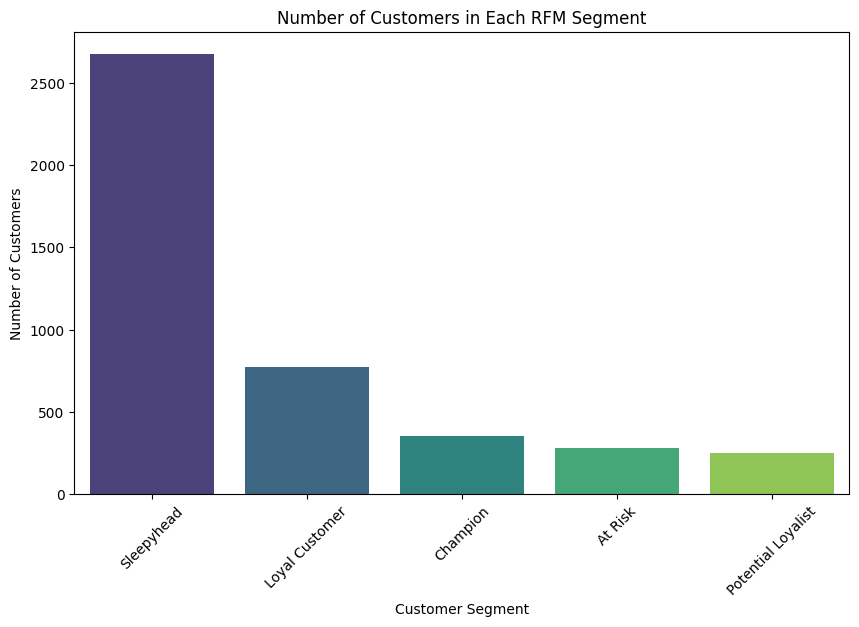

In [470]:
# Plotting the segments

# Counting customers in each segment
segment_counts = rfm_data['Customer_Segment'].value_counts()

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette="viridis")
plt.title('Number of Customers in Each RFM Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


In [471]:
segment_counts

Customer_Segment
Sleepyhead            2678
Loyal Customer         770
Champion               355
At Risk                281
Potential Loyalist     251
Name: count, dtype: int64




Definition of the Customer Segments:

1. "Champions" (555): These customers have high scores in all three dimensions: they buy often, spend a lot and have bought recently
    --> Promotions: Loyalty programs, VIP status, special offers

2. "Loyal Customers" (55x, 54x, 45x, 44x): Customers who buy frequently (but may not have the highest spend)
    --> Promotions: Cross-selling, recommendations for new products

3. "Potential Loyalists" (53x, 52x, 51x): Customers who have recently purchased and have more potential to become loyal
    --> Promotions: Incentives for further purchases, discounts
    --> buying experience benefits

4. "Recent Customers" (5xx): Customers who have recently purchased but may not spend often or spend a lot
    --> Promotions: Follow-up communication, welcome offers
    --> buying experience benefits

5. "At Risk" (14x, 15x, 24x, 25x): Customers who used to be good customers but haven't purchased in a while 
    --> Promotions: Reactivation campaigns, special discounts
    --> activating a loyalty program and special benefits

7. "Sleepyhead" (x1x, x2x): Customers who have not purchased for a long time and may have churned
    --> Promotions: Exploratory surveys, reactivation offers

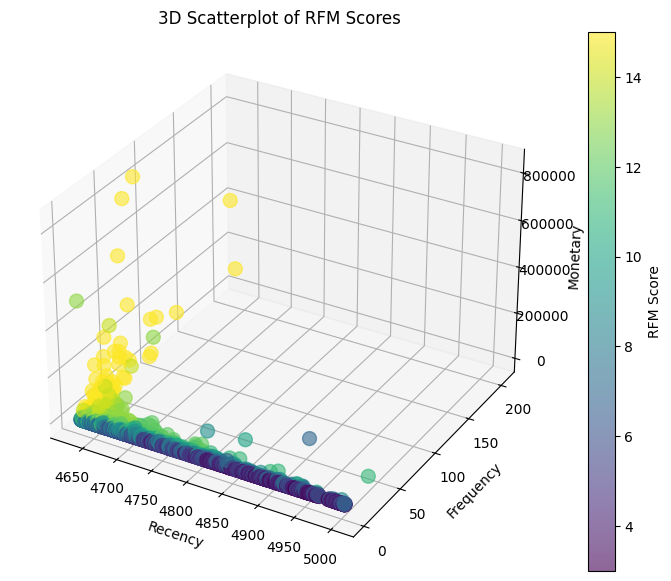

In [475]:
#visualization 3D scatterplot

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 3D-Scatterplot erstellen
scatter = ax.scatter(rfm_data['Recency'], rfm_data['Frequency'], rfm_data['Monetary'],
                     c=rfm_data['RFM_Score'], cmap='viridis', s=100, alpha=0.6)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatterplot of RFM Scores')

fig.colorbar(scatter, ax=ax, label='RFM Score')
plt.show()


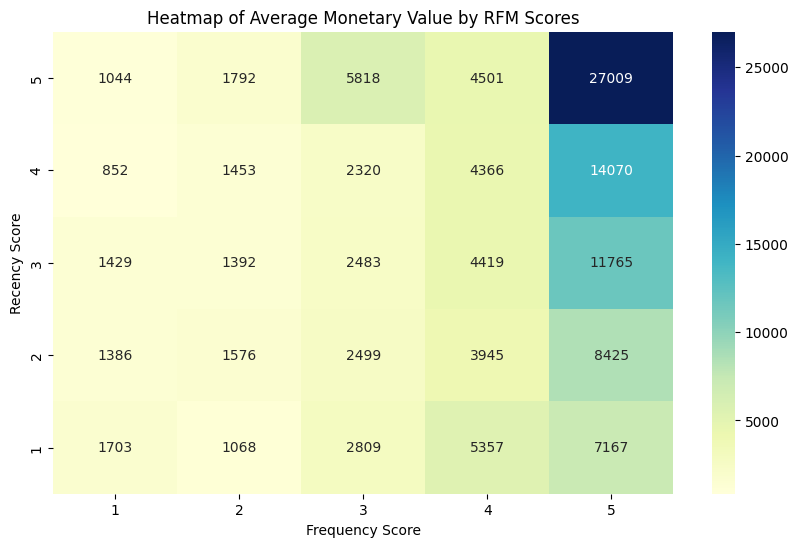

In [476]:
# Pivot for heatmap
rfm_pivot = rfm_data.pivot_table(index='R_Score', columns='F_Score', values='Monetary', aggfunc='mean')

# Heatmap 
plt.figure(figsize=(10, 6))
sns.heatmap(rfm_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Heatmap of Average Monetary Value by RFM Scores')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()


Findings:

- the 3D scatter plot provides a visual representation of the relationships between the RFM dimensions
- the heatmap visualizes the distribution of the RFM scores and the average monetary values

--> there are 2 main developments: frequent repeat buyers with a medium monetary investment and few repeat buyers with a small to a very high investment
--> this may be due to the fact that it is a young company that has yet to gain a foothold in the market or because we only had data from 1 financial year at our disposal 


In [467]:
#show the new customer table with customer segments
data = rfm_data[['customer_id', 'RFM_Segment', 'Customer_Segment']]
df = pd.DataFrame(data)


df


,customer_id,RFM_Segment,Customer_Segment
0,u12346,115,Sleepyhead
1,u12347,555,Champion
2,u12348,244,At Risk
3,u12349,414,Sleepyhead
4,u1235,112,Sleepyhead
...,...,...,...
4330,u1828,121,Sleepyhead
4331,u18281,121,Sleepyhead
4332,u18282,531,Potential Loyalist
4333,u18283,555,Champion


In [473]:
# Display the top customers based on RFM Score
top_customers = rfm_data.sort_values(by='RFM_Score', ascending=False).head(10)
top_customers

,customer_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Customer_Segment
3661,u17365,4642,8,14286.96,5,5,5,555,15,Champion
3660,u17364,4630,11,13388.04,5,5,5,555,15,Champion
4294,u18229,4641,20,21830.70,5,5,5,555,15,Champion
4290,u18225,4633,12,16514.88,5,5,5,555,15,Champion
3619,u17306,4640,19,25893.93,5,5,5,555,15,Champion
1008,u13709,4633,13,18922.95,5,5,5,555,15,Champion
3645,u17346,4633,15,7868.64,5,5,5,555,15,Champion
953,u1363,4635,7,6095.34,5,5,5,555,15,Champion
2586,u15861,4642,8,9440.76,5,5,5,555,15,Champion
935,u13599,4631,21,15449.76,5,5,5,555,15,Champion


In [474]:
# Display the low customers based on CLV
low_customers = rfm_data.sort_values(by='RFM_Score', ascending=True).head(10)
low_customers

,customer_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Customer_Segment
1486,u14373,4988,1,229.65,1,1,1,111,3,Sleepyhead
1487,u14375,4815,1,706.68,1,1,1,111,3,Sleepyhead
1494,u14386,4926,1,427.20,1,1,1,111,3,Sleepyhead
551,u1307,4822,1,686.40,1,1,1,111,3,Sleepyhead
552,u13072,4896,1,531.45,1,1,1,111,3,Sleepyhead
572,u13101,4864,1,303.57,1,1,1,111,3,Sleepyhead
586,u1312,4868,1,91.80,1,1,1,111,3,Sleepyhead
594,u13132,4891,1,231.90,1,1,1,111,3,Sleepyhead
605,u13144,4962,1,332.85,1,1,1,111,3,Sleepyhead
6,u12353,4834,1,267.00,1,1,1,111,3,Sleepyhead


3. Conclusions and Recommendations

RFM analysis segments customers based on their buying behavior into categories such as Recency (how recently), Frequency (how often), and Monetary (how much). Each customer group requires different marketing strategies to maximize engagement and retention. 

1. champions (high recency, high frequency, high monetary)

Description: These customers are the best customers who buy often and a lot.

Strategies:

- VIP programs: Reward them with exclusive offers, discounts or early access to new products.

- Loyalty programs: Implement special rewards programs to cement their loyalty.

- Personalized marketing: Send tailored offers based on their buying behavior.

- Gather feedback: Leverage their positive attitude towards the brand to get valuable feedback.

2. loyal customers (high frequency, medium to high monetary)

Description: These customers buy regularly, show loyalty, but may not have the highest spend.
Strategies:

- Cross-sell and upsell: recommend products that complement their previous purchases.

- Referral Programs: Encourage them to refer friends and family by offering incentives.

- Extended memberships: Offer discounts on future purchases or memberships to build customer loyalty.

- Content marketing: Offer valuable content that keeps them interested.

3. potential loyalists (high recency, medium frequency, medium monetary)
   
Description: These customers have recently purchased and could become loyal customers.

Strategies:

- Welcome programs: Offer special discounts or coupons for their next purchase.

- Email marketing: Send regular emails with attractive offers to keep them engaged.

- Proactive customer care: Contact them after purchase to ensure they are satisfied.

- Discounts for their next order: Encourage them to come back sooner.

4. recent customers (high recency, low frequency, low monetary)

Description: These customers have recently made a purchase, but possibly for the first time.

Strategies:

- Follow-up campaigns: send post-purchase thank you messages or surveys to build customer loyalty.

- Incentives to repeat: Offer incentives for the next purchase, such as discounts or free shipping options.

- Loyalty programs: Introduce special reward programs to induce their future loyalty.

- Product suggestions: Based on their first purchase, suggest similar or complementary products.

- Onboarding: Offer tutorials, guides or product information to maximize the value of the purchase.

5. at risk (low recency, high frequency, high monetary)

Description: These customers have bought a lot in the past, but less recently.

Strategies:

- Reactivation campaigns: send a targeted campaign with special offers to win them back.

- Exclusive discounts: Offer time-limited discounts or special promotions to motivate them to buy more.

- Personalized approach: Use personalized emails or even phone calls to get their attention.

- Reminder campaigns: Use trigger emails to remind them of past purchases and win back their loyalty.

6. sleepyheads (low recency, low frequency, low monetary)

Description: These customers have not bought for a long time and have never been very active.

Strategies:

- Win-back campaigns: send strong special offers or discounts to win them back.

- Market research: Conduct surveys to understand why they have become inactive with incentive for participation.

- Content re-engagement: Use email series or blogs to get them interested in the brand again.

- Introduce product innovations: Introduce new products or features that might attract them.